# 00 - Preparation

In [1]:
from nimlab import datasets as nimds
import numpy as np
from nilearn import image, plotting, maskers
import nibabel as nib
import os
import pandas as pd
import glob
import platform
import warnings
warnings.filterwarnings('ignore')
import nilearn

Set BIDS Directory Information

In [ ]:
## Paths Input Here
bids_base_directory = '/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/grafman/derivatives'
session_number = '01'
#----------------------------------------------------------------DO NOT TOUCH
out_dir = os.path.join(bids_base_directory, 'neuroimaging_analyses', (f'ses-{session_number}'), 'sub-all', 'spatial_correlation')
print('Will save to: ', out_dir)
os.makedirs(out_dir, exist_ok=True)

# 01 - Imports

**A) Import Niftis from Folders**

**Import The First Matrix**

Enter Information Relating to the Path of the First Set of Niftis

In [ ]:
basename_target_1 = r'/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/grafman/derivatives/network_maps/memory/rmap/r_map'
file_pattern_target_1 = r'*/*.nii*'


Enter Information Regarding How You Want to Handle the Niftis

In [ ]:
remove_zero = False
z_score_df1 = False
rfz_transform_target1 = False
threshold_df1 = False
take_absolute_value = False

Import the Niftis

In [ ]:
import numpy as np
from calvin_utils.file_utils.import_matrices import import_matrices_from_folder
from calvin_utils.nifti_utils.matrix_utilities import threshold_matrix

def process_matrices(
    basename_target, 
    file_pattern_target, 
    z_score_df=False, 
    rfz_transform_target=False, 
    threshold_df=False, 
    take_absolute_value=True
):
    """
    Process matrices from a given directory and file pattern.
    
    Parameters:
    - basename_target (str): Path to the directory containing the matrices.
    - file_pattern_target (str): File pattern to match matrices.
    - remove_zero (bool, optional): A flag which, if implemented, would remove zero values. Default is False.
    - z_score_df (bool, optional): Apply z-scoring to the matrices. Default is False.
    - rfz_transform_target (bool, optional): Apply Fisher's r-to-z transformation to the matrices. Default is False.
    - threshold_df (bool, optional): Apply thresholding to the matrices. Default is False.
    - take_absolute_value (bool, optional): Convert matrix values to their absolute values. Default is True.
    
    Returns:
    - DataFrame: Processed matrices
    """
    
    matrix_df = import_matrices_from_folder(connectivity_path=basename_target, file_pattern=file_pattern_target)
    
    if z_score_df:
        from calvin_utils.statistical_utils.z_score_matrix import z_score_matrix
        for col in matrix_df.columns:
            matrix_df[col] = matrix_df[col].apply(lambda x: z_score_matrix(x))
    
    if rfz_transform_target:
        from calvin_utils.statistical_utils.fisher_z_transform import fisher_z_transform
        for col in matrix_df.columns:
            matrix_df[col] = matrix_df[col].apply(lambda x: fisher_z_transform(x))
    
    if threshold_df:
        matrix_df = threshold_matrix(matrix_df, threshold=2, probability=False, direction='keep_greater')
    
    if take_absolute_value:
        matrix_df = np.abs(matrix_df)
    
    return matrix_df


In [ ]:
matrix_df1 = process_matrices(
    basename_target=basename_target_1,
    file_pattern_target=file_pattern_target_1,
    z_score_df=z_score_df1,
    rfz_transform_target=rfz_transform_target1,
    threshold_df=threshold_df1,
    take_absolute_value=take_absolute_value,
)
matrix_df1.tail(3)

**Import the Second Matrix**

Enter Information Relating to the Path of the First Set of Niftis

In [ ]:
basename_target_2 = r'/Users/cu135/Dropbox (Partners HealthCare)/resources/published_networks/niftis'
file_pattern_target_2 = r'Memory Network.nii'

Enter Information Regarding How You Want to Handle the Niftis

In [ ]:
z_score_df2 = False
rfz_transform_target2 = False
threshold_df2 = False
take_absolute_value2 = False

Import the Niftis

In [ ]:
matrix_df2 = process_matrices(
    basename_target=basename_target_2,
    file_pattern_target=file_pattern_target_2,
    z_score_df=z_score_df2,
    rfz_transform_target=rfz_transform_target2,
    threshold_df=threshold_df2,
    take_absolute_value=take_absolute_value2,
)
matrix_df2.tail(3)

matrix_df2 = matrix_df2.abs()

Merge Dataframes

In [ ]:
import pandas as pd
import numpy as np

def join_dataframes(matrix_df1, matrix_df2):
    """
    Joins two dataframes side by side and returns the merged dataframe.
    
    Parameters:
    - matrix_df1 (DataFrame): The first dataframe to join.
    - matrix_df2 (DataFrame): The second dataframe to join.
    
    Returns:
    - DataFrame: The merged dataframe created by joining matrix_df1 and matrix_df2 side by side.
    """
    
    # Reset indexes of the input dataframes
    matrix_df1.reset_index()
    matrix_df2.reset_index()
    
    # Print lengths of the dataframes
    print('df1 len: ', len(matrix_df1), ' matrix_df2 len: ', len(matrix_df2))
    
    # Concatenate the dataframes side by side
    merged_df = pd.concat([matrix_df1, matrix_df2], axis=1, ignore_index=False)
    
    # Print the number of non-zero elements in the last column
    print('Nonzero values in last column: ', np.count_nonzero(merged_df.iloc[:,-1]))
    try:
        merged_df.pop('index')
    except:
        pass
    return merged_df

# Example usage:
# Assuming matrix_df1 and matrix_df2 are already defined
# result_df = join_dataframes(matrix_df1, matrix_df2)


In [ ]:
merged_df = join_dataframes(matrix_df1, matrix_df2)
merged_df

**B) Import Niftis from a CSV**

In [9]:
from calvin_utils.file_utils.import_matrices import import_matrices_from_csv
merged_df = import_matrices_from_csv('/Users/cu135/Dropbox (Partners HealthCare)/studies/ccm_memory/metadata/path_to_sante_rho_maps.csv')
merged_df

,generated_nifti.nii,Memory difficulties Percent Change Corrected V2_Month 12/generated_nifti.nii,Any trouble with Memory-number Percent Change Corrected V2_Month 6/generated_nifti.nii,Memory difficulties Percent Change Corrected V2_Month 6/generated_nifti.nii,Trouble remembering-number Percent Change Corrected V2_Month 24/generated_nifti.nii,Trouble remembering-number Percent Change Corrected V2_Month 12/generated_nifti.nii,Trouble remembering-number Percent Change Corrected V2_Month 6/generated_nifti.nii,Any trouble with Memory-number Percent Change Corrected V2_Month 24/generated_nifti.nii,Any trouble with Memory-number Percent Change Corrected V2_Month 12/generated_nifti.nii,MemoryV/generated_nifti.nii,...,gvar703/generated_nifti.nii,gvar702/generated_nifti.nii,gvar705/generated_nifti.nii,mmse3/generated_nifti.nii,mmse5/generated_nifti.nii,Lesions Causing Amnesia.nii,Memory Network.nii,TRIAL_TOTAL_CORRECT_generated_nifti.nii,Q2 change/generated_nifti.nii,r_map/generated_nifti.nii
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
902625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
902626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
902627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


from calvin_utils.file_utils import import_matrices_from_csv


Mask Within A Given Template Space

# 02 - Masking

In [10]:
import numpy as np
from nimlab import datasets as nimds
from nilearn import image

def apply_mask_to_dataframe(merged_df, mask_path=None):
    """
    Apply a mask to a dataframe using either a provided mask or the default MNI ICBM152 mask.
    
    Parameters:
    - merged_df (DataFrame): The dataframe to which the mask should be applied.
    - mask_path (str, optional): The path to the mask image. If not provided, the MNI ICBM152 mask will be used.
    
    Returns:
    - DataFrame: The masked dataframe containing only the rows specified by the mask.
    
    Example usage:
    >>> masked_df = apply_mask_to_dataframe(merged_df, mask_path=None)
    """
    
    # Load the mask data based on the provided mask_path or use default mask
    if mask_path is not None:
        brain_indices = np.where(image.load_img(mask_path).get_fdata().flatten() > 0)[0]
    else:
        mni_mask = nimds.get_img("mni_icbm152")
        mask_data = mni_mask.get_fdata().flatten()
        brain_indices = np.where(mask_data > 0)[0]
    
    # Apply the mask to the dataframe
    masked_df = merged_df.iloc[brain_indices]
    
    return masked_df




In [11]:
masked_df = apply_mask_to_dataframe(merged_df, mask_path=None)
masked_df

,generated_nifti.nii,Memory difficulties Percent Change Corrected V2_Month 12/generated_nifti.nii,Any trouble with Memory-number Percent Change Corrected V2_Month 6/generated_nifti.nii,Memory difficulties Percent Change Corrected V2_Month 6/generated_nifti.nii,Trouble remembering-number Percent Change Corrected V2_Month 24/generated_nifti.nii,Trouble remembering-number Percent Change Corrected V2_Month 12/generated_nifti.nii,Trouble remembering-number Percent Change Corrected V2_Month 6/generated_nifti.nii,Any trouble with Memory-number Percent Change Corrected V2_Month 24/generated_nifti.nii,Any trouble with Memory-number Percent Change Corrected V2_Month 12/generated_nifti.nii,MemoryV/generated_nifti.nii,...,gvar703/generated_nifti.nii,gvar702/generated_nifti.nii,gvar705/generated_nifti.nii,mmse3/generated_nifti.nii,mmse5/generated_nifti.nii,Lesions Causing Amnesia.nii,Memory Network.nii,TRIAL_TOTAL_CORRECT_generated_nifti.nii,Q2 change/generated_nifti.nii,r_map/generated_nifti.nii
93491,-0.072198,-0.053740,0.055543,0.011742,0.162386,0.019043,0.173235,0.088744,0.014880,-0.231702,...,-0.018950,0.064154,0.058939,NaN,-0.159020,2.878096,-0.057329,-0.062494,0.064350,0.083339
93492,-0.121443,-0.038111,-0.104106,-0.111695,0.239102,0.054991,0.166312,0.049837,-0.081083,-0.252691,...,-0.013479,0.025639,0.078736,NaN,-0.148457,2.606874,-0.063376,-0.070278,-0.014216,0.098888
93493,-0.140832,-0.044637,-0.073034,-0.084189,0.248701,0.069906,0.174871,0.069842,-0.044640,-0.269687,...,-0.009356,-0.011585,0.105867,NaN,-0.131046,2.212765,-0.070855,-0.084017,-0.128138,0.108749
93582,0.082521,0.059618,0.104878,0.131621,0.072509,-0.057167,0.133091,0.113996,0.044257,-0.231639,...,-0.020537,0.071367,0.055851,NaN,-0.151496,3.029796,-0.053693,-0.071665,0.005510,0.085164
93583,-0.161869,-0.042004,-0.086848,-0.105930,0.257133,0.071896,0.180881,0.061828,-0.066529,-0.250342,...,-0.014616,0.028053,0.079428,NaN,-0.144213,2.778456,-0.058415,-0.078455,-0.073688,0.096549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798193,0.135557,0.062061,-0.024237,0.076450,-0.142946,0.015008,-0.160491,-0.051169,0.065533,-0.081509,...,0.056243,0.043665,0.182975,NaN,0.025032,4.865715,0.023294,-0.092555,-0.228813,0.088015
798281,0.125832,0.051546,-0.005274,0.062697,-0.149728,-0.020047,-0.167328,-0.023482,0.069057,-0.053851,...,0.012415,0.047308,0.151818,NaN,0.009453,5.956623,0.032668,-0.104783,-0.241041,0.036661
798282,0.143634,0.073740,-0.016469,0.079154,-0.161320,-0.015919,-0.184894,-0.038949,0.065686,-0.056444,...,0.026338,0.049583,0.159946,NaN,0.010611,5.565621,0.035310,-0.096582,-0.243345,0.048792
798283,0.147384,0.068187,-0.024793,0.078781,-0.163694,0.004426,-0.169670,-0.049920,0.057126,-0.066704,...,0.042058,0.051632,0.166927,NaN,0.016640,5.290926,0.039092,-0.088370,-0.243704,0.067879


# 03 - Spatial Correlation

**Perform Correlation**

method_choices:
- 0 = pearson
- 1 = spearman
- 2 = kendall

In [12]:
method_choice = 0
only_compare_nonzero_voxels=True

In [13]:
import pandas as pd
from tqdm import tqdm
from natsort import natsorted

def compute_correlation(df, method_choice=0, only_compare_nonzero_voxels=False):
    """
    Compute correlations among columns of a DataFrame using a specified method.
    When only_compare_nonzero_voxels is True, only pairs of non-zero voxels are used for the computation.
    
    Parameters:
    - df (DataFrame): The dataframe for which correlations should be computed.
    - method_choice (int, optional): An integer indicating the correlation method to be used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    - only_compare_nonzero_voxels (bool, optional): Flag to determine whether to compute correlations 
                                                    considering only non-zero voxels. Default is False.
    
    Returns:
    - DataFrame: The correlation matrix.
    
    Example usage:
    >>> corr_matrix = compute_correlation(df, method_choice=0, only_compare_nonzero_voxels=True)
    """
    
    methods = ['pearson', 'spearman', 'kendall']
    method = methods[method_choice]
    
    # If only_compare_nonzero_voxels is False, compute the correlation in the usual manner
    if not only_compare_nonzero_voxels:
        return df.corr(method=method), method
    else:
        columns = df.columns
        n = len(columns)
        
        # Initialize a dataframe to store the results
        corr_df = pd.DataFrame(index=columns, columns=columns, dtype='float64')
        
        # Iterate over each pair of columns
        for i in tqdm(range(n)):
            for j in range(i, n):
                # Filter rows where both columns have non-zero values
                temp_df = df[(df[columns[i]] != 0) & (df[columns[j]] != 0)]
                
                # Compute correlation for the filtered rows
                corr_value = temp_df[[columns[i], columns[j]]].corr(method=method).iloc[0, 1]
                
                # Assign the computed value to the result dataframe
                corr_df.iloc[i, j] = corr_value
                corr_df.iloc[j, i] = corr_value
                
    #Sort the Dataframe            
    corr_df = corr_df.reindex(index=natsorted(corr_df.index))
    corr_df = corr_df.reindex(columns=natsorted(corr_df.columns))
    return corr_df, method


In [14]:
only_compare_nonzero_voxels=True

In [15]:
corr_df, method = compute_correlation(masked_df, method_choice=method_choice, 
                                      only_compare_nonzero_voxels=only_compare_nonzero_voxels)
corr_df

100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


,Any trouble with Memory-number Percent Change Corrected V2_Month 6/generated_nifti.nii,Any trouble with Memory-number Percent Change Corrected V2_Month 12/generated_nifti.nii,Any trouble with Memory-number Percent Change Corrected V2_Month 24/generated_nifti.nii,Lesions Causing Amnesia.nii,Memory Network.nii,Memory difficulties Percent Change Corrected V2_Month 6/generated_nifti.nii,Memory difficulties Percent Change Corrected V2_Month 12/generated_nifti.nii,MemoryS/generated_nifti.nii,MemoryV/generated_nifti.nii,Q2 change/generated_nifti.nii,...,gvar699/generated_nifti.nii,gvar700/generated_nifti.nii,gvar701/generated_nifti.nii,gvar702/generated_nifti.nii,gvar703/generated_nifti.nii,gvar704/generated_nifti.nii,gvar705/generated_nifti.nii,mmse3/generated_nifti.nii,mmse5/generated_nifti.nii,r_map/generated_nifti.nii
Any trouble with Memory-number Percent Change Corrected V2_Month 6/generated_nifti.nii,1.000000,0.660711,0.389464,0.057977,0.068918,0.272475,0.238853,-0.065930,0.030385,-0.104763,...,-0.225445,0.065834,-0.304975,0.039281,0.191446,0.169384,0.015319,NaN,0.024114,0.233958
Any trouble with Memory-number Percent Change Corrected V2_Month 12/generated_nifti.nii,0.660711,1.000000,0.451634,0.028191,0.008149,0.572061,0.221522,0.041148,0.114012,-0.003946,...,-0.235711,0.216427,-0.122345,0.063036,0.335433,0.055648,0.157004,NaN,0.046287,0.321315
Any trouble with Memory-number Percent Change Corrected V2_Month 24/generated_nifti.nii,0.389464,0.451634,1.000000,-0.015660,0.018000,-0.080149,-0.061541,-0.083480,0.099097,0.008918,...,-0.170552,-0.148647,-0.183619,0.072405,0.188461,0.149798,0.030349,NaN,0.130083,0.019511
Lesions Causing Amnesia.nii,0.057977,0.028191,-0.015660,1.000000,0.571437,-0.052744,0.028015,-0.029798,-0.175908,-0.144899,...,0.325317,0.303398,0.090142,-0.170751,-0.201827,-0.246625,0.044256,NaN,-0.168939,0.104457
Memory Network.nii,0.068918,0.008149,0.018000,0.571437,1.000000,-0.011325,0.152938,0.022143,-0.111005,-0.040149,...,0.177613,0.099925,0.049446,-0.186487,-0.172753,-0.105026,0.055932,NaN,-0.057488,-0.001116
Memory difficulties Percent Change Corrected V2_Month 6/generated_nifti.nii,0.272475,0.572061,-0.080149,-0.052744,-0.011325,1.000000,0.550901,0.128442,0.070899,-0.109550,...,-0.082761,0.265672,0.041861,0.000468,0.152260,-0.045594,0.159494,NaN,-0.068726,0.172965
Memory difficulties Percent Change Corrected V2_Month 12/generated_nifti.nii,0.238853,0.221522,-0.061541,0.028015,0.152938,0.550901,1.000000,-0.061241,-0.120801,-0.207480,...,0.056675,0.174729,0.013314,-0.178158,-0.021927,0.045342,0.239143,NaN,-0.131345,0.095980
MemoryS/generated_nifti.nii,-0.065930,0.041148,-0.083480,-0.029798,0.022143,0.128442,-0.061241,1.000000,0.259489,0.017833,...,0.147639,0.291917,0.179008,-0.109843,-0.077451,-0.193053,-0.173444,NaN,-0.150526,0.204305
MemoryV/generated_nifti.nii,0.030385,0.114012,0.099097,-0.175908,-0.111005,0.070899,-0.120801,0.259489,1.000000,0.041354,...,-0.344752,-0.336294,-0.094912,0.208432,0.395167,0.192531,-0.182783,NaN,0.237522,0.058123
Q2 change/generated_nifti.nii,-0.104763,-0.003946,0.008918,-0.144899,-0.040149,-0.109550,-0.207480,0.017833,0.041354,1.000000,...,-0.279025,-0.191256,0.012302,0.035460,0.003852,0.155787,-0.214664,NaN,0.163517,-0.087111


**Visualize the Correlation Matrix**

<AxesSubplot: >

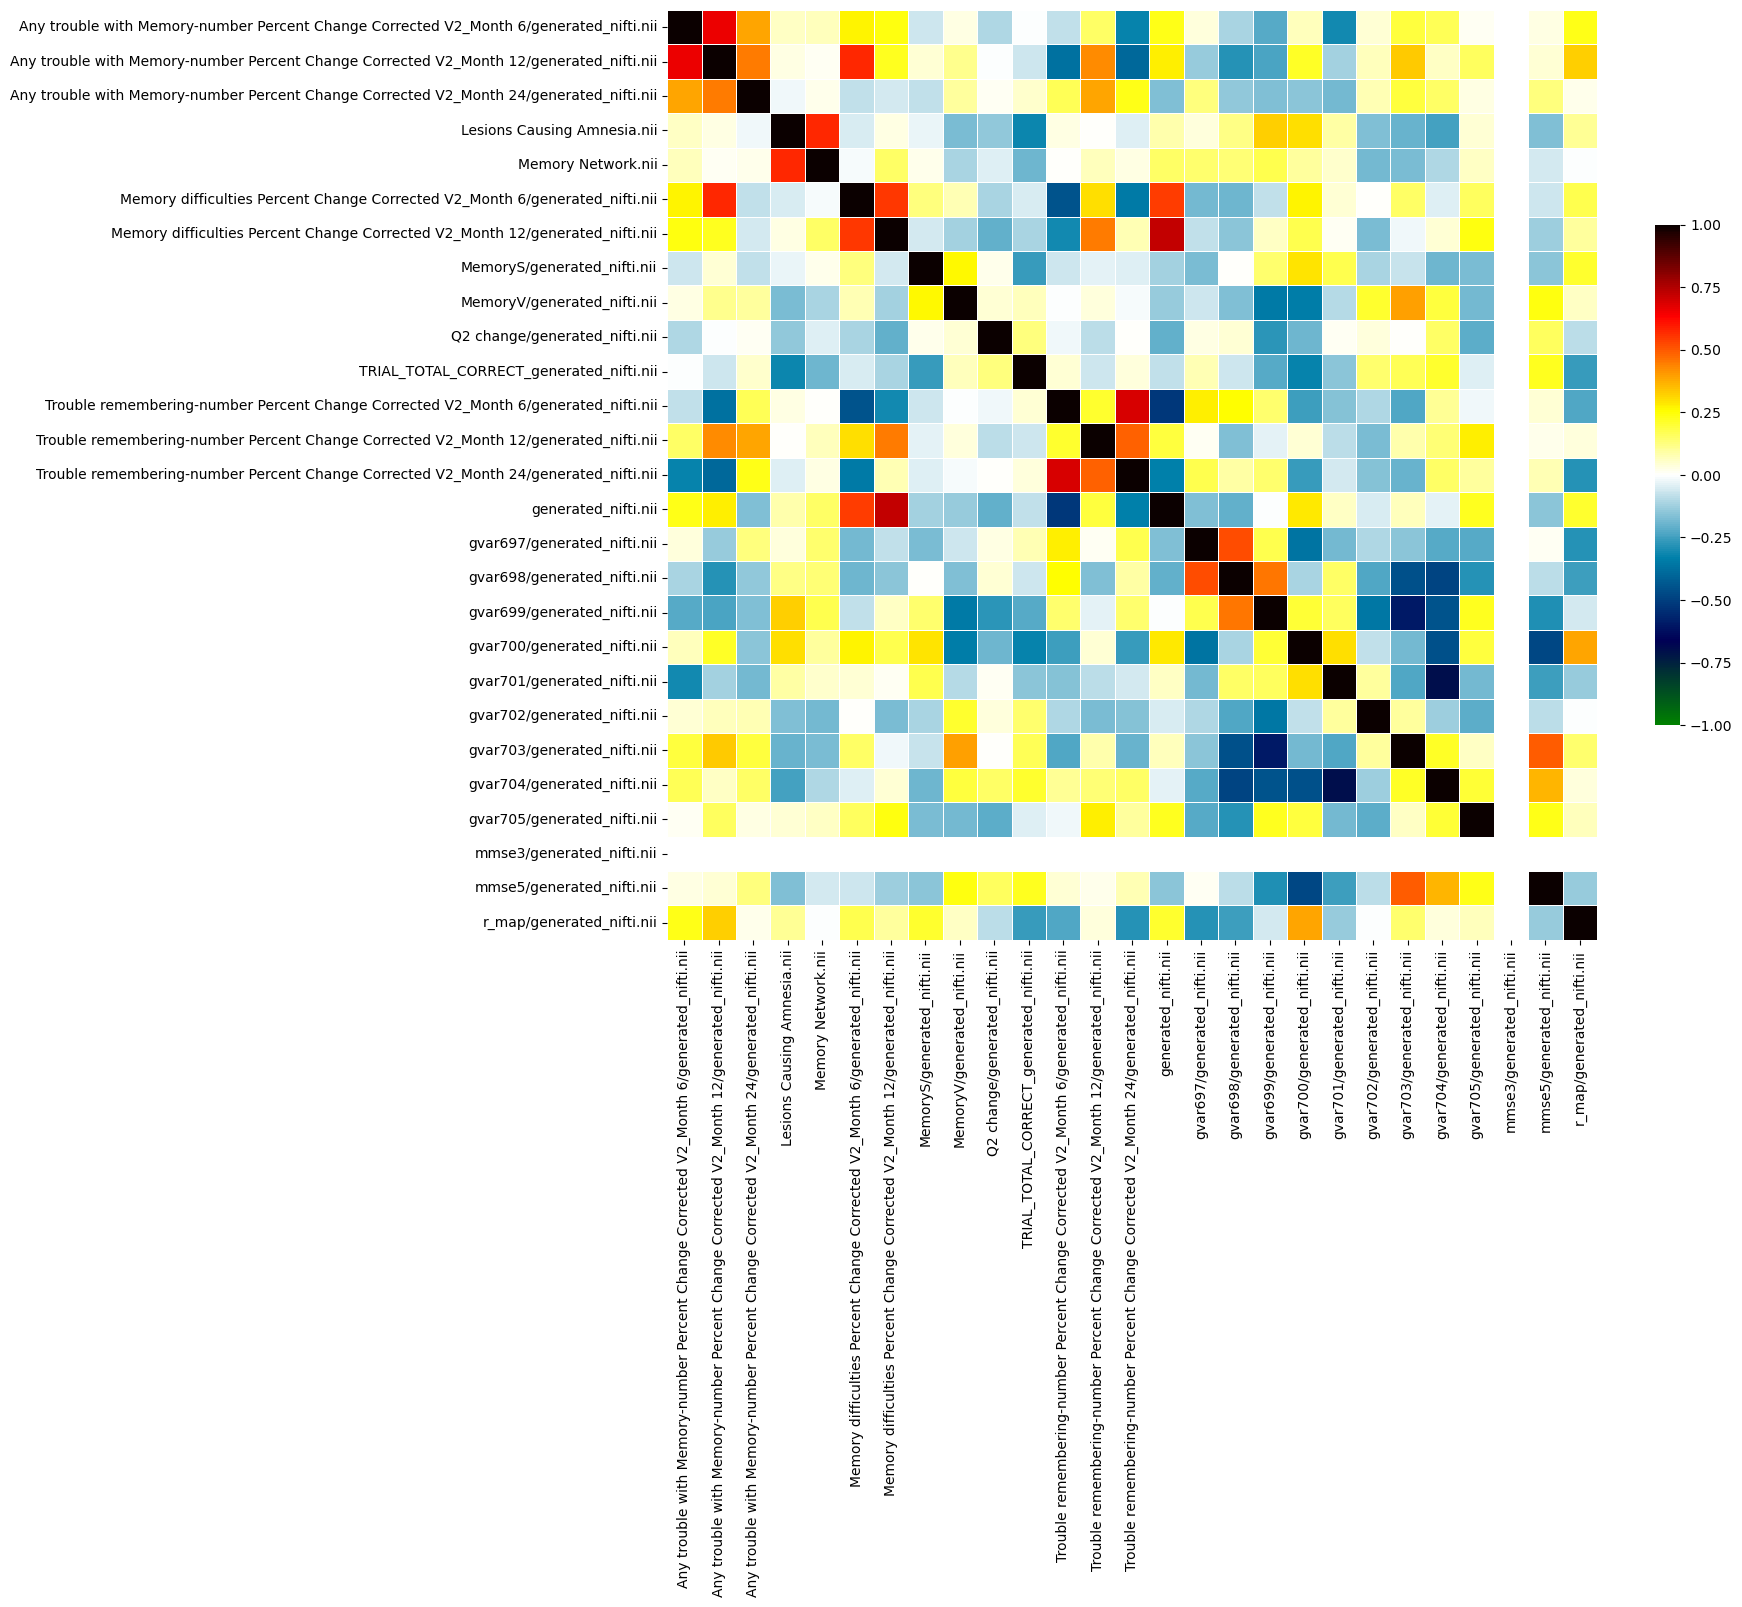

In [16]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(corr_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)          

**Save The Figure & Dataframe**
- enter the name of your comparison below

In [ ]:
import os

def save_correlation_results(corr_df, fig, out_dir, comparison, save=False, method_choice=0):
    """
    Save the correlation dataframe and figure to specified output directory.
    
    Parameters:
    - out_dir (str): The base directory where the results should be saved.
    - comparison (str): The specific comparison or sub-directory under out_dir.
    - save (bool, optional): Flag to determine whether to save results. Default is False.
    - method_choice (int, optional): An integer indicating the correlation method used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    
    Example usage:
    >>> save_correlation_results('/path/to/output', 'specific_comparison', save=True, method_choice=1)
    """
    
    if save:
        out_dir = os.path.join(out_dir, comparison)
        os.makedirs(out_dir, exist_ok=True)

        corr_df.to_csv(os.path.join(out_dir, f'{method_choice}_correlation_df.csv'))
        fig.savefig(os.path.join(out_dir, f'{method_choice}_correlation_matrix.png'))
        print('saved to ' + os.path.join(out_dir, f'{method_choice}_correlation_matrix.png'))


In [ ]:
comparison = 'z_score_atrophy_index'
save_results = True

In [ ]:
save_correlation_results(corr_df=corr_df, fig=fig, out_dir=out_dir, comparison=comparison, save=save_results, method_choice=method_choice)

**Extract the Cross-Correlation Matrix**

In [ ]:
def extract_cross_correlation_diagonal(corr_df):
    """
    Extracts the diagonal of the cross-correlation from the given correlation matrix.
    
    Parameters:
    - corr_df (DataFrame): The correlation matrix.
    
    Returns:
    - DataFrame: The diagonal of the cross-correlation with the patient identifiers as the index.
    
    Example usage:
    >>> cross_corr_diag = extract_cross_correlation_diagonal(corr_df)
    """
    
    # Assuming the dataframe is square and has an even number of columns,
    # split it into two equal parts
    n = len(corr_df)
    half_n = n // 2
    
    # Extract the values from the intersection of the rows of the first dataset 
    # and the columns of the second dataset
    cross_corr_values = [corr_df.iloc[i, i + half_n] for i in range(half_n)]
    
    # Convert to DataFrame while maintaining the index from the original corr_df
    cross_corr_df = pd.DataFrame(cross_corr_values, index=corr_df.index[:half_n], columns=["Cross-Correlation"])
    
    return cross_corr_df



In [ ]:
cross_corr_diagonal_df = extract_cross_correlation_diagonal(corr_df)
cross_corr_diagonal_df

In [ ]:
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))
sns.heatmap(cross_corr_diagonal_df, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)       

Save Results

In [ ]:
import os

def save_cross_correlation_results(corr_df, fig, out_dir, comparison, save=False, method_choice=0):
    """
    Save the correlation dataframe and figure to specified output directory.
    
    Parameters:
    - out_dir (str): The base directory where the results should be saved.
    - comparison (str): The specific comparison or sub-directory under out_dir.
    - save (bool, optional): Flag to determine whether to save results. Default is False.
    - method_choice (int, optional): An integer indicating the correlation method used. 
                                     0: Pearson (default), 1: Spearman, 2: Kendall.
    
    Example usage:
    >>> save_correlation_results('/path/to/output', 'specific_comparison', save=True, method_choice=1)
    """
    
    if save:
        out_dir = os.path.join(out_dir, comparison)
        os.makedirs(out_dir, exist_ok=True)

        corr_df.to_csv(os.path.join(out_dir, f'{method_choice}_cross_correlation_df.csv'))
        fig.savefig(os.path.join(out_dir, f'{method_choice}_cross_correlation_matrix.png'))
        print('saved to ' + os.path.join(out_dir, f'{method_choice}_cross_correlation_matrix.png'))

In [ ]:
save_results = True

In [ ]:
save_cross_correlation_results(corr_df=cross_corr_diagonal_df, fig=fig, out_dir=out_dir, comparison=comparison, save=save_results, method_choice=method_choice)

## Show Specific Heatmap

In [ ]:
print(corr_df.columns)

In [ ]:
#Enter networks of interest
network_of_interest = 'Memory Network.nii'
networks_of_disinterest = [
    None   
]

#---isolate network of interest and remove those not of interest
corr_df_2 = corr_df.copy()
corr_df_2 = pd.DataFrame(corr_df_2.loc[:, network_of_interest])
if networks_of_disinterest[0] is not None:
    for network in networks_of_disinterest:
        corr_df_2.drop(network, inplace=True)
#Sort the dataframe by descending order
corr_df_2 = corr_df_2.sort_values(network_of_interest)
#Remove .nii from file names
for name in corr_df_2.columns.values:
    newname = name.split('.nii')[0]
    corr_df_2 = corr_df_2.rename({name: newname}, axis='columns')
for name in corr_df_2.index.values:
    newname = name.split('.nii')[0]
    corr_df_2 = corr_df_2.rename({name: newname}, axis='index')

#---Visualize the new data
#Create heatmap of correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 13))

sns.heatmap(corr_df_2, cmap='ocean_hot',square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)

#Save results
fig.savefig(out_dir + f'/spcorrel_{network_of_interest}.png')
fig.savefig(out_dir + f'/spcorrel_{network_of_interest}.svg')
corr_df_2.to_csv(out_dir + f'/spcorrel_{network_of_interest}.csv')
display(corr_df_2)
print(out_dir)